In [55]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Softmax, Dropout
from tensorflow.keras import optimizers

### Loading Data

In [2]:
df = pd.read_excel(r'C:\Users\khasy\OneDrive\Documents\GitHub\Projects\Assignment 1\Cars_Data_full.xlsx')
df

,Price,Age,KM,Fuel,HP,MC,Color,Auto,CC,Drs,...,AC,Comp,CD,Clock,Pwin,PStr,Radio,SpM,M_Rim,Tow_Bar
0,21000,26,31463,Petrol,195,0,Silver,0,1800,3,...,1,0,1,1,1,1,0,0,1,0
1,20000,23,43612,Petrol,195,0,Red,0,1800,3,...,1,1,0,1,1,1,0,1,1,0
2,19650,26,32191,Petrol,195,0,Red,0,1800,3,...,1,1,0,1,1,1,0,1,1,0
3,21550,32,23002,Petrol,195,1,Black,0,1800,3,...,1,1,1,1,1,1,0,1,1,0
4,22550,33,34133,Petrol,195,1,Grey,0,1800,3,...,1,1,1,1,1,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1362,7550,70,20546,Petrol,89,1,Blue,0,1300,3,...,0,0,0,1,1,1,0,1,0,0
1363,10895,73,19002,Petrol,89,0,Grey,0,1300,3,...,0,0,0,0,0,1,0,1,0,0
1364,8550,72,17018,Petrol,89,0,Blue,0,1300,3,...,0,0,0,0,0,1,0,0,0,0
1365,7300,71,16918,Petrol,89,1,Grey,0,1300,3,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df.info() #Checks the datatypes of the features
#Fuel has only two values: Petrol or Deisel - Can be converted to an integer using Binary encoding
#Color needs to converted to an integer using label encoding

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1367 entries, 0 to 1366
Data columns (total 28 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Price    1367 non-null   int64 
 1   Age      1367 non-null   int64 
 2   KM       1367 non-null   int64 
 3   Fuel     1367 non-null   object
 4   HP       1367 non-null   int64 
 5   MC       1367 non-null   int64 
 6   Color    1367 non-null   object
 7   Auto     1367 non-null   int64 
 8   CC       1367 non-null   int64 
 9   Drs      1367 non-null   int64 
 10  Cyl      1367 non-null   int64 
 11  Grs      1367 non-null   int64 
 12  Wght     1367 non-null   int64 
 13  G_P      1367 non-null   int64 
 14  Mfr_G    1367 non-null   int64 
 15  ABS      1367 non-null   int64 
 16  Abag_1   1367 non-null   int64 
 17  Abag_2   1367 non-null   int64 
 18  AC       1367 non-null   int64 
 19  Comp     1367 non-null   int64 
 20  CD       1367 non-null   int64 
 21  Clock    1367 non-null   int64 
 22  

### Encoding Categorical Data

In [34]:
#Convert Fuel type to integer using binary encoding
Fuel_dict = {'Petrol': 1,
            'Diesel': 0} #Assign 1 & 0 for petrol and deisel respectively
df['Fuel_type'] = df.Fuel.map(Fuel_dict)

#Convert Color to integer using label encoding
new_lbl = LabelEncoder()
df['Color_code'] = new_lbl.fit_transform(df['Color'])
df_new = df.drop(['Fuel', 'Color'], axis = 1)

### Feature Selection

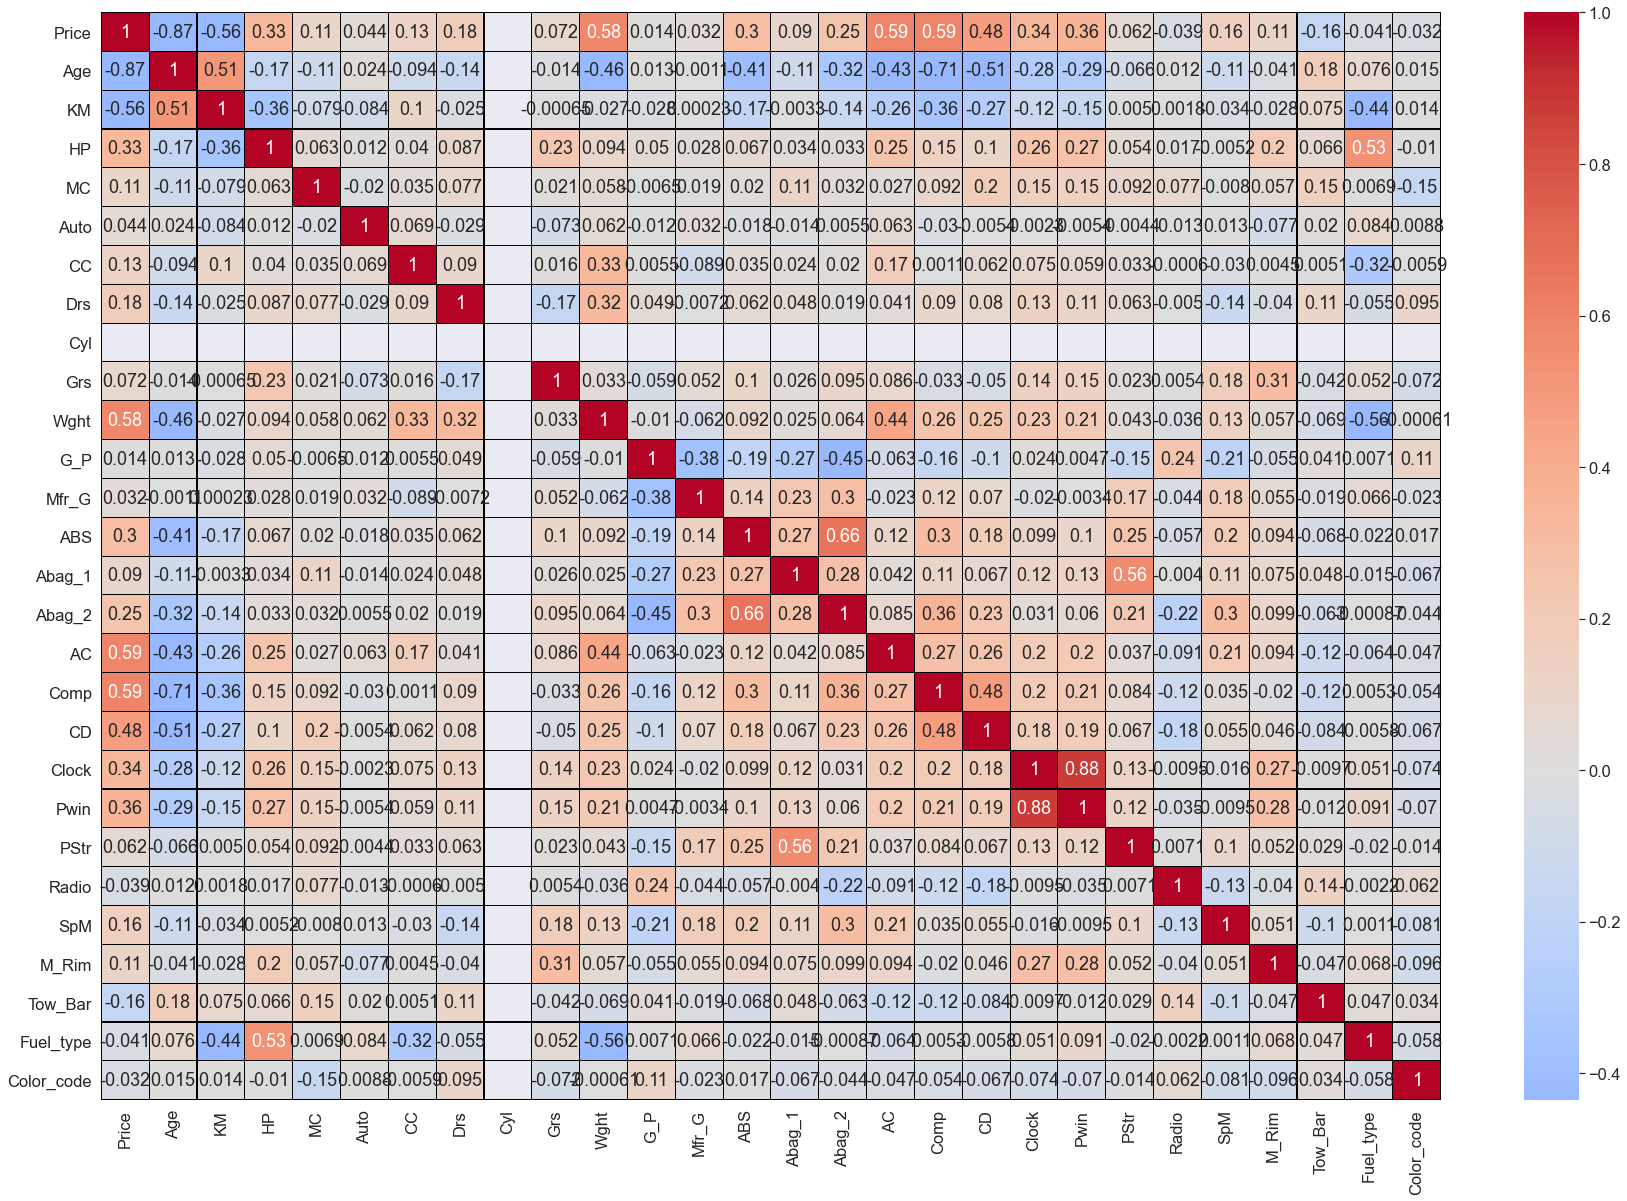

In [5]:
#Check for correlation between the features and the target variable using pearson correlation
correlation = df_new.corr(method='pearson')
#Plot the correlation matrix
plt.figure(figsize=(30,20))
sns.set(font_scale=1.5)
sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, cmap='coolwarm', annot=True, 
            linewidths = 0.1, linecolor='black',robust = True, annot_kws={"size": 18}, center= 0)
#Sort the features in descending correlation 
features_sort = correlation.sort_values('Price',ascending = False)

In [35]:


#Establishing the features and the target parameters
X = df_new.drop(columns=['Price'])
y = df_new.Price

#Combining correlation and p-value test
lin_reg = sm.OLS(y,X).fit()
p = lin_reg.pvalues
p_df = pd.DataFrame(p)
p_df.columns = ['p_value']
correlation_new = correlation['Price'].copy()
correlation_new = correlation_new.drop(['Price'], axis =0)
corr_df = pd.DataFrame(correlation_new)
corr_df.columns = ['Correlation']
features_df = pd.concat([corr_df,p_df], axis = 1)

#Setting criterias for the features based on correlation and p_value
features_df = features_df.loc[(features_df['Correlation'] > 0.2) | (features_df['Correlation'] < -0.2) & (features_df['p_value'] < 0.05) ]

##Only Age, KM, Wght, AC and CD meet the criteria comfortably
features_df = features_df.drop(['HP','ABS','Abag_2','Comp','Clock','Pwin'], axis=0)
#Final features
df_new = df[['Price','Age','KM','Wght','AC','CD']]

# Normalize all values to bring them to a similar scale (Normalizing data brings all values to within 0 & 1)
x = df_new.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_new.loc[:,:] = x_scaled
df_new

C:\Users\khasy\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Price,Age,KM,Wght,AC,CD
0,0.589698,0.276316,0.135057,0.300813,1.0,1.0
1,0.554174,0.236842,0.187212,0.300813,1.0,0.0
2,0.541741,0.276316,0.138182,0.300813,1.0,0.0
3,0.609236,0.355263,0.098734,0.300813,1.0,1.0
4,0.644760,0.368421,0.146519,0.300813,1.0,1.0
...,...,...,...,...,...,...
1362,0.111901,0.855263,0.088190,0.040650,0.0,0.0
1363,0.230728,0.894737,0.081562,0.024390,0.0,0.0
1364,0.147425,0.881579,0.073045,0.024390,0.0,0.0
1365,0.103020,0.868421,0.072616,0.024390,0.0,0.0


### Model Preparation

In [36]:
#Establishing the features and the target parameters
X = df_new.drop(columns=['Price'])
y = df_new.Price

#Splitting the data into training and testing (80% - Training and 20% - Testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 100)
len(X_train.columns)

#Cross-Validation grid serach
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
hyper_params = [{'n_features_to_select': list(range(1,6))}] #Range selected based on the number of features
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm) #Recursive Feature Elimination used as the estimator
model_cv = GridSearchCV(estimator = rfe,
                       param_grid = hyper_params,
                       scoring = 'r2',
                       cv = folds,
                       verbose = 1,
                       return_train_score = True)
model_cv.fit(X_train, y_train)

cv_result = pd.DataFrame(model_cv.cv_results_)
cv_result

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.006183,9.771747e-04,0.001995,8.844012e-07,1,{'n_features_to_select': 1},0.696443,0.766544,0.763016,0.772507,...,0.760347,0.034973,5,0.777806,0.758322,0.759370,0.757276,0.748972,0.760349,0.009473
1,0.005587,7.975276e-04,0.002194,3.987789e-04,2,{'n_features_to_select': 2},0.751938,0.807402,0.798760,0.826671,...,0.798437,0.024981,4,0.813043,0.797883,0.800205,0.793679,0.797335,0.800429,0.006645
2,0.004581,4.827722e-04,0.002201,4.134895e-04,3,{'n_features_to_select': 3},0.823477,0.817853,0.852893,0.872757,...,0.840733,0.020055,3,0.849318,0.849858,0.842120,0.837725,0.845438,0.844892,0.004552
3,0.003989,2.431402e-07,0.001997,5.342704e-06,4,{'n_features_to_select': 4},0.855133,0.844363,0.862002,0.899317,...,0.867095,0.018875,1,0.873734,0.876285,0.871987,0.863672,0.868425,0.870820,0.004394
4,0.003590,4.887742e-04,0.002194,3.997804e-04,5,{'n_features_to_select': 5},0.856300,0.839258,0.863487,0.899890,...,0.867029,0.020313,2,0.874100,0.877937,0.872297,0.864227,0.868686,0.871450,0.004683


### Linear Regression Model

In [37]:
#Based on the features selected, the grid search shows the the best result can be attained with all 5 features

#Establish linear regression model 
lin_reg_mod = LinearRegression()
lin_reg_mod.fit(X_train, y_train)

#Predict based on the linear regression model & metrics
pred = lin_reg_mod.predict(X_test)
test_set_rmse = (np.sqrt(mean_squared_error(y_test, pred)))
test_set_r2 = r2_score(y_test,pred)*100

print('The R^2 score is', test_set_r2)
print('The RMSE is', test_set_rmse)

The R^2 score is 86.96669978121412
The RMSE is 0.04502203602721583


### Neural Network Model

In [72]:
model = Sequential()

#Input Layer
model.add(Dense(X.shape[1], activation='relu', input_dim = X.shape[1]))

#Hidden Layers
model.add(Dense(units = 512, kernel_initializer='normal', activation='relu')) 
model.add(Dropout(0.2))

model.add(Dense(units = 512, kernel_initializer='normal', activation='relu')) 
model.add(Dropout(0.3))

model.add(Dense(units = 256, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(units = 128, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units = 64, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.6))

model.add(Dense(units = 64, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.7))

#Output Layer
model.add(Dense(units = 1, kernel_initializer='normal', activation = 'relu'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_51 (Dense)             (None, 512)               3072      
_________________________________________________________________
dropout_24 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_25 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_26 (Dropout)         (None, 256)              

In [77]:
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.fit(X_train, y_train, epochs = 25, batch_size = 32)

Epoch 1/25
35/35 [==============================] - 0s 3ms/step - loss: 0.0053 - mse: 0.0053
Epoch 2/25
35/35 [==============================] - 0s 3ms/step - loss: 0.0046 - mse: 0.0046
Epoch 3/25
35/35 [==============================] - 0s 3ms/step - loss: 0.0050 - mse: 0.0050
Epoch 4/25
35/35 [==============================] - 0s 3ms/step - loss: 0.0044 - mse: 0.0044
Epoch 5/25
35/35 [==============================] - 0s 3ms/step - loss: 0.0051 - mse: 0.0051
Epoch 6/25
35/35 [==============================] - 0s 3ms/step - loss: 0.0050 - mse: 0.0050A: 0s - loss: 0.0050 - mse: 0.00
Epoch 7/25
35/35 [==============================] - 0s 3ms/step - loss: 0.0050 - mse: 0.0050
Epoch 8/25
35/35 [==============================] - 0s 3ms/step - loss: 0.0045 - mse: 0.0045
Epoch 9/25
35/35 [==============================] - 0s 3ms/step - loss: 0.0049 - mse: 0.0049
Epoch 10/25
35/35 [==============================] - 0s 3ms/step - loss: 0.0045 - mse: 0.0045
Epoch 11/25
35/35 [==================

In [82]:
nn_pred = model.predict(X_test)
test_nn_r2 = r2_score(y_test,nn_pred)*100
test_nn_rmse = (np.sqrt(mean_squared_error(y_test, nn_pred)))
print('The R^2 score is', test_nn_r2)
print('The RMSE is', test_nn_rmse)

The R^2 score is 84.60378773480815
The RMSE is 0.048933341862059575
